# Projekt IUM. Etap 1. Iteracja 3.
## Andrii Gamalii, Wiktor Topolski 
### Zadanie “Większość serwisów udostępniających muzykę czy filmiki, poleca coś swoim użytkownikom. Przyszedł czas, abyśmy zaczęli robić tak samo”

# Definicja problemu biznesowego, definicja zadania modelowania i wszystkich założeń, propozycja kryteriów sukcesu

## Problem biznesowy
Polecenie utworów użytkownikom serwisu do strumieniowania muzyki

## Założenia
Rekomendacje pojawiają się na ekranie startowym  
Rekomendujemy użytkownikowi 10 różnych utworów  
Rekomendacje będą generowane w czasie rzeczywistym przy uruchomieniu aplikacji i odświeżeniu ekranu startowego  
Model będzie retrenowany z nowymi danymi codziennie w nocy  

## Zadanie modelowania
Generacja rekomendacji na podstawie logów sesji użytkowników

Dane trenujące: część wszystkich sesji do danego momentu w czasie

Wejście modelu: N ostatnich akcji użytkownika - traktujemy sesje użytkownika jako jedną wielką sesję  
Wyjście modelu: 10 różnych utworów najbardziej pasujących do preferencji użytkownika   

Opracowany zostanie model, który od razu generuje 10 rekomendacji  

## Kryteria sukcesu
Biznesowe: użytkownicy są zadowoleni z rekomendacji  
- Jak mierzymy: w aplikacji pytamy użytkownika czy jest zadowolony z rekomendacji  

Analityczne: zarekomendowane utwory nie zostały pominięte przez użytkownika  
- Jak mierzymy: procent rekomendowanych utworów które zostały pominięte w niedalekiej przyszłości przez danego użytkownika

Biznesowe: użytkownicy wybierają rekomendacje  
- Jak mierzymy: ilość klinęć w rekomendacje na ilość generowanych rekomendacji  

Analityczne: użytkownik wybierze 1 z 10 zaproponowanych utworów  
- Jak mierzymy: procent rekomendowanych utworów które zostały odsłuchane w niedalekiej przyszłości przez danego użytkownika

## Przykładowe punkty odniesienia
1. Model wybierający 10 najbardziej popularnych piosenek  
2. Model wybierający najczęściej słuchane piosenki przez użytkowników z danymi ulubionymi gatunkami muzycznymi

# Analiza danych

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [66]:
# Wczytywanie danych z plików

artists_df_orig = pd.read_json("./data/artists.jsonl", lines=True)
sessions_df_orig = pd.read_json("./data/sessions.jsonl", lines=True)
tracks_df_orig = pd.read_json("./data/tracks.jsonl", lines=True)
users_df_orig = pd.read_json("./data/users.jsonl", lines=True)

## Wykonawcy

In [67]:
# Sprawdzenie ile jest rekordów z brakującymi wartościami
print(artists_df_orig.describe(), "\n\n")

artists_df = artists_df_orig.copy(deep=True)
print("Liczba rekordów", len(artists_df))
print("Liczba unikalnych rekordów po id", len(artists_df[['id']].drop_duplicates()))
print("Wyniki: ")
for c in artists_df.columns:
    incomplete_rows = artists_df[artists_df[[c]].isnull().any(axis=1)]
    print(c, len(incomplete_rows))

                            id       name  \
count                     1667       1667   
unique                    1667       1667   
top     7jVv8c5Fj3E9VhNjxT4snq  Lil Nas X   
freq                         1          1   

                                                   genres  
count                                                1667  
unique                                               1357  
top     [latin, latin hip hop, reggaeton, reggaeton fl...  
freq                                                   15   


Liczba rekordów 1667
Liczba unikalnych rekordów po id 1667
Wyniki: 
id 0
name 0
genres 0


Tabela wykonawcy zawiera id, informacje o nazwie i gatunkach danego wykonawcy

### Wnioski
Niektóre nazwy mają zakodowane znaki w Unicode. Aplikacja korzystająca z systemu rekomendacji musi takie nazwy móc obsługiwać.  
Atrybuty:
- Kolumna genres może być przydatna by grupować podobnych artystów

## Sesje

In [68]:
# Sprawdzenie ile jest rekordów z brakującymi wartościami
print(sessions_df_orig.describe(exclude=[np.number]), "\n\n")

sessions_df = sessions_df_orig.copy(deep=True)
print("Liczba rekordów", len(sessions_df))

print("Liczba unikalnych rekordów", len(sessions_df.drop_duplicates()))
print("Wyniki: ")
for c in sessions_df.columns:
    incomplete_rows = sessions_df[sessions_df[[c]].isnull().any(axis=1)]
    print(c, len(incomplete_rows))

                            timestamp                track_id event_type
count                        11934332                10328740   11934332
unique                            NaN                   15009          4
top                               NaN  4xqrdfXkTW4T0RauPLv3WA       play
freq                              NaN                    6797    6350963
mean    2022-12-08 17:34:16.376276736                     NaN        NaN
min               2021-12-07 23:26:42                     NaN        NaN
25%     2022-06-09 11:26:57.768750080                     NaN        NaN
50%     2022-12-08 20:10:12.039000064                     NaN        NaN
75%     2023-06-09 11:45:42.025999872                     NaN        NaN
max        2023-12-08 11:57:44.407000                     NaN        NaN 


Liczba rekordów 11934332
Liczba unikalnych rekordów 11932802
Wyniki: 
session_id 0
timestamp 0
user_id 0
track_id 1605592
event_type 0


Tabela sesje zawiera id sesji, znaczniki czasowe, id użytkownika, id utworu i typ zdarzenia.  
Jest sporo powtarzających się rekordów. Sprawdźmy, co to za rekordy.

In [69]:
# jakie są nieunikalne rekordy
duplicates = sessions_df[sessions_df.duplicated(keep="first")]
print("Liczba nieunikalnych rekordów", len(duplicates))
print(duplicates)

print(duplicates.describe(exclude=[np.number]), "\n\n")

Liczba nieunikalnych rekordów 1530
          session_id               timestamp  user_id track_id    event_type
6884             691 2022-08-31 12:30:41.615      101     None  advertisment
11148           1030 2022-07-26 13:16:11.709      102     None  advertisment
20041           1321 2023-11-26 13:55:50.617      102     None  advertisment
22979           1422 2022-05-19 15:42:45.577      102     None  advertisment
26279           1529 2023-05-21 21:21:11.324      102     None  advertisment
...              ...                     ...      ...      ...           ...
11812657      555630 2022-09-08 08:13:21.273     1092     None  advertisment
11842308      557029 2023-09-02 20:55:29.081     1094     None  advertisment
11865451      558319 2023-07-01 16:29:18.891     1095     None  advertisment
11907990      560720 2022-05-30 02:28:00.118     1098     None  advertisment
11909464      560801 2023-01-26 08:34:24.503     1098     None  advertisment

[1530 rows x 5 columns]
                

Te powtarzające się rekordy mają event_type advertisement, więc i tak ich nie użyjemy, nie musimy się tym martwić. Dane są OK

In [70]:
print("Unikalne wartości event_type", sessions_df['event_type'].unique())

Unikalne wartości event_type ['play' 'advertisment' 'like' 'skip']


Niektóre rekordy zawierają wartość 'advertisment' w kolumnie event_type, są one nam nie potrzebne
Możemy bez konsekwencji je usunąć

In [71]:
# liczba rekordów z event_type = 'advertisment'

sessions_df = sessions_df_orig.copy(deep=True)
print(len(sessions_df[sessions_df['event_type'].isin(['advertisment'])]))

1605592


Jest tego sporo...

In [72]:
# Sprawdzenie ile jest rekordów z brakującymi wartościami wyłączając takie z event_type = 'advertisment'

sessions_df = sessions_df_orig.copy(deep=True)
# Usuwanie event_type = 'advertisment'
sessions_df = sessions_df[sessions_df['event_type'].isin(['skip', 'like', None, 'play'])]

print("Liczba rekordów", len(sessions_df))
print("Wyniki: ")
for c in sessions_df.columns:
    incomplete_rows = sessions_df[sessions_df[[c]].isnull().any(axis=1)]
    print(c, len(incomplete_rows))

Liczba rekordów 10328740
Wyniki: 
session_id 0
timestamp 0
user_id 0
track_id 0
event_type 0


In [73]:
# liczba rekordów z brakującymi track_id lub event_type
print(len(sessions_df[sessions_df[["track_id", "event_type"]].isnull().any(axis=1)]))

0


In [74]:
sessions_df = sessions_df_orig.copy(deep=True)

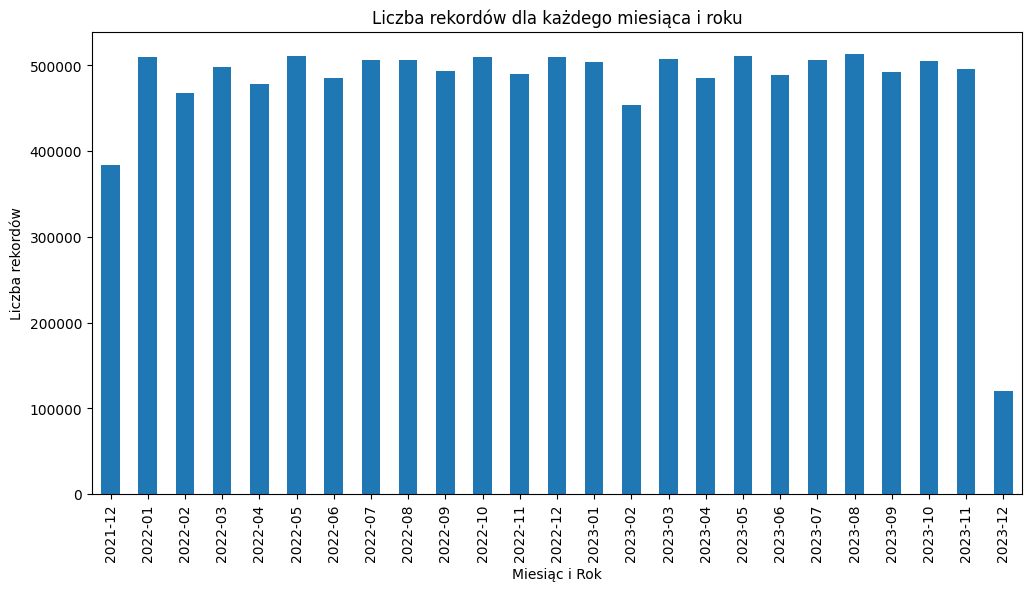

In [75]:
sessions_df['timestamp'] = pd.to_datetime(sessions_df['timestamp'])
sessions_df['month_year'] = sessions_df['timestamp'].dt.to_period('M')
monthly_yearly_records = sessions_df.groupby(sessions_df['timestamp'].dt.to_period('M')).size()

plt.figure(figsize=(12, 6))
monthly_yearly_records.plot(kind='bar')
plt.title('Liczba rekordów dla każdego miesiąca i roku')
plt.xlabel('Miesiąc i Rok')
plt.ylabel('Liczba rekordów')
plt.show()

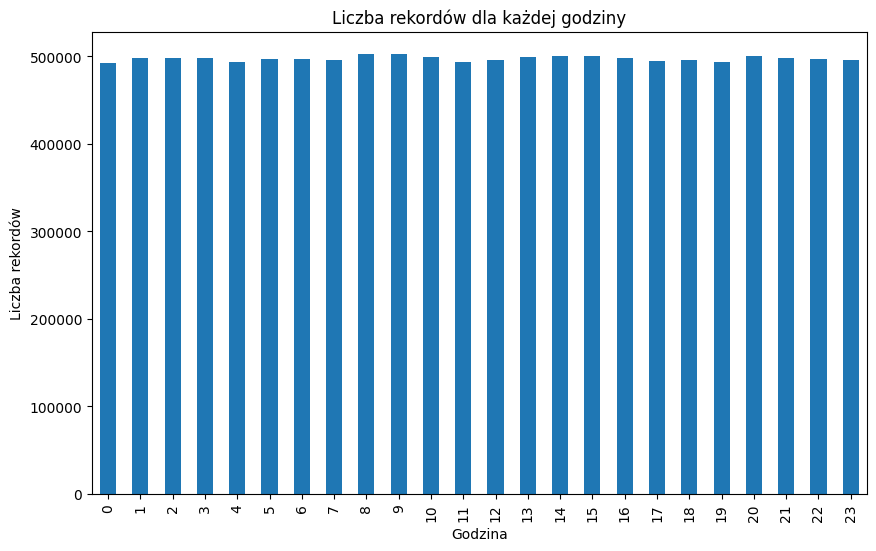

In [76]:
sessions_df['timestamp'] = pd.to_datetime(sessions_df['timestamp'])
sessions_df['hour'] = sessions_df['timestamp'].dt.hour
hourly_records = sessions_df.groupby('hour').size()

plt.figure(figsize=(10, 6))
hourly_records.plot(kind='bar')
plt.title('Liczba rekordów dla każdej godziny')
plt.xlabel('Godzina')
plt.ylabel('Liczba rekordów')
plt.show()

### Wnioski
- Tabela przedstawiająca co słuchają użytkownicy i w jakiej kolejności. Jest kluczowa dla trenowania modelu. Bez niej jakość rekomendacji byłaby zdecydowanie mniejsza.  
- Wszystkie pola tabeli są przydatne.  
- Informacja o polubionych i pominiętych przez użytkowników piosenkach niesie realną informację o ich upodobaniach

#### Wykresy
- Dane zgrupowane po miesiącach i latach są równomiernie rozłożone poza pierwszym i ostanim miesiącem, to jest spowodowane tym, że ta próba danych zaczyna się w około 1/4 miesiąca i kończy na 1/4 miesiąca.  
- Dane zgrupowane po godzinach są równomiernie rozłożone, co jest dziwne, ponieważ ludzie słuchają w nocy mniej niż w dzień. To wzbudza podejrzenie, że timestamp nie jest w tej samej strefie czasowej co użytkownik. Przez to godzina w której slucha słuchacz jest nieznana.


## Utwory

In [77]:
# Sprawdzenie ile jest rekordów z brakującymi wartościami
print(tracks_df_orig.describe(), "\n\n")

tracks_df = tracks_df_orig.copy(deep=True)
print("Liczba rekordów", len(tracks_df))
print("Liczba unikalnych rekordów", len(tracks_df.drop_duplicates()))
print("Wyniki: ")
for c in tracks_df.columns:
    incomplete_rows = tracks_df[tracks_df[[c]].isnull().any(axis=1)]
    print(c, len(incomplete_rows))

         popularity   duration_ms      explicit  danceability        energy  \
count  22412.000000  2.241200e+04  22412.000000  22412.000000  22412.000000   
mean      61.375602  2.301383e+05      0.166607      0.599096      0.648017   
std        8.048246  7.209562e+04      0.372633      0.158259      0.209577   
min       51.000000  3.062200e+04      0.000000      0.000000      0.000103   
25%       55.000000  1.914930e+05      0.000000      0.495000      0.508000   
50%       60.000000  2.206670e+05      0.000000      0.608000      0.672000   
75%       67.000000  2.562400e+05      0.000000      0.715000      0.816000   
max       99.000000  4.120258e+06      1.000000      0.980000      0.999000   

                key      loudness   speechiness  acousticness  \
count  22412.000000  22412.000000  22412.000000  22412.000000   
mean       5.278824     -7.196227      0.082914      0.267758   
std        3.558813      3.738098      0.089317      0.276111   
min        0.000000    -44.4

Tabela utwory zawiera id utworu, nazwę utworu, popularność utworu, długość utworu, czy jest wulgarna, id artysty, data wydania i parametry opisujące sam utwór

                  popularity  duration_ms  explicit  danceability    energy  \
popularity          1.000000    -0.100334  0.125075      0.099837 -0.024840   
duration_ms        -0.100334     1.000000 -0.078894     -0.208840  0.023085   
explicit            0.125075    -0.078894  1.000000      0.215368  0.044694   
danceability        0.099837    -0.208840  0.215368      1.000000  0.061990   
energy             -0.024840     0.023085  0.044694      0.061990  1.000000   
key                -0.011926     0.003404  0.009114      0.026259  0.023190   
loudness            0.080061    -0.037607  0.070906      0.167208  0.711682   
speechiness         0.042863    -0.092929  0.446432      0.198476  0.115530   
acousticness       -0.036805    -0.079043 -0.075631     -0.079132 -0.647608   
instrumentalness   -0.069268     0.084455 -0.064273     -0.178896 -0.135806   
liveness           -0.061163     0.022050 -0.009399     -0.081979  0.160070   
valence            -0.026563    -0.186587 -0.073251 

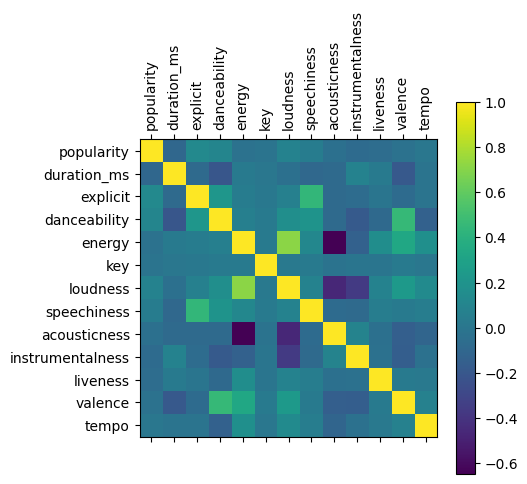

In [78]:
tracks_df = tracks_df_orig.copy(deep=True)
tracks_df = tracks_df.select_dtypes(include=np.number)

corr = tracks_df.corr()
print(corr)
plt.matshow(corr)
continuous_features = tracks_df.describe().columns
plt.xticks(range(len(continuous_features)), continuous_features, rotation=90)
plt.yticks(range(len(continuous_features)), continuous_features, rotation=0)
plt.colorbar()
plt.show()

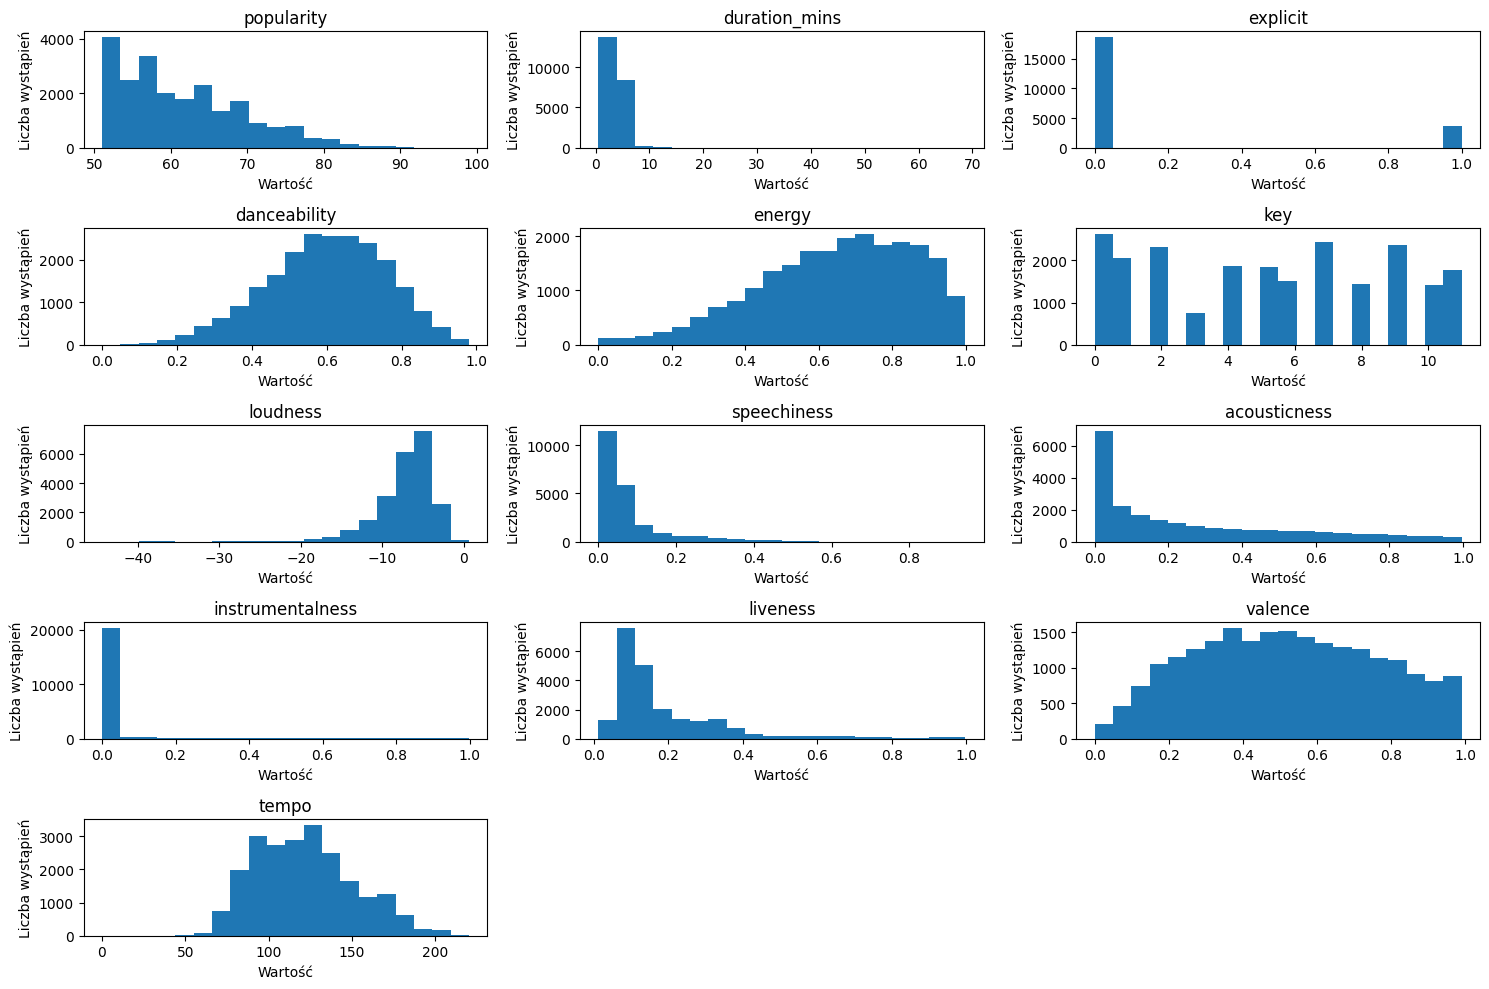

In [79]:
tracks_df = tracks_df_orig.copy(deep=True)
numeric_columns = ['popularity', 'duration_mins', 'explicit', 'danceability', 'energy', 'key', 'loudness',
                   'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

num_cols = 3
num_rows = (len(numeric_columns) + num_cols - 1) // num_cols
plt.figure(figsize=(15, 10))

tracks_df['duration_mins'] = tracks_df['duration_ms'] / 60000
tracks_df = tracks_df.drop('duration_ms', axis=1)

for i, col in enumerate(numeric_columns, start=1):
    plt.subplot(num_rows, num_cols, i)
    plt.hist(tracks_df[col], bins=20)
    plt.title(col)
    plt.xlabel('Wartość')
    plt.ylabel('Liczba wystąpień')

plt.tight_layout()
plt.show()

### Wnioski
- Wartości atrybutów popularity, key, tempo i loudness nie są z zakresu [0,1], trzeba będzie je znormalizować przed trenowaniem na etapie preprocessingu danych.
- Wszystkie atrybuty zostaną poddane normalizacji.  
- Atrybuty numeryczne niosą informacje o podobieństwie utworów, więc wszystkie są przydatne.

#### Wykresy
- Największa wartość współczynnika korelacji została zaobserwowana dla atrybutów loudness/energy i jest równa 0.712 => możemy rozważyć nieużycia jednego z nich.
- Rozkłady danych są ciekawe.

## Użytkownicy

In [80]:
# Sprawdzenie ile jest rekordów z brakującymi wartościami
print(users_df_orig.describe(), "\n\n")

users_df = users_df_orig.copy(deep=True)
print("Liczba rekordów", len(users_df))
print("Liczba unikalnych rekordów", len(users_df["user_id"].drop_duplicates()))
print("Wyniki: ")
for c in users_df.columns:
    incomplete_rows = users_df[users_df[[c]].isnull().any(axis=1)]
    print(c, len(incomplete_rows))

           user_id  name  city  street
count  1000.000000   0.0   0.0     0.0
mean    600.500000   NaN   NaN     NaN
std     288.819436   NaN   NaN     NaN
min     101.000000   NaN   NaN     NaN
25%     350.750000   NaN   NaN     NaN
50%     600.500000   NaN   NaN     NaN
75%     850.250000   NaN   NaN     NaN
max    1100.000000   NaN   NaN     NaN 


Liczba rekordów 1000
Liczba unikalnych rekordów 1000
Wyniki: 
user_id 0
name 1000
city 1000
street 1000
favourite_genres 0
premium_user 0


Tabela użytkownicy zawiera id użytkownika, imię(puste), adres(puste), ulubione gatunki, czy jest użytkownikiem premium

<Figure size 2000x500 with 0 Axes>

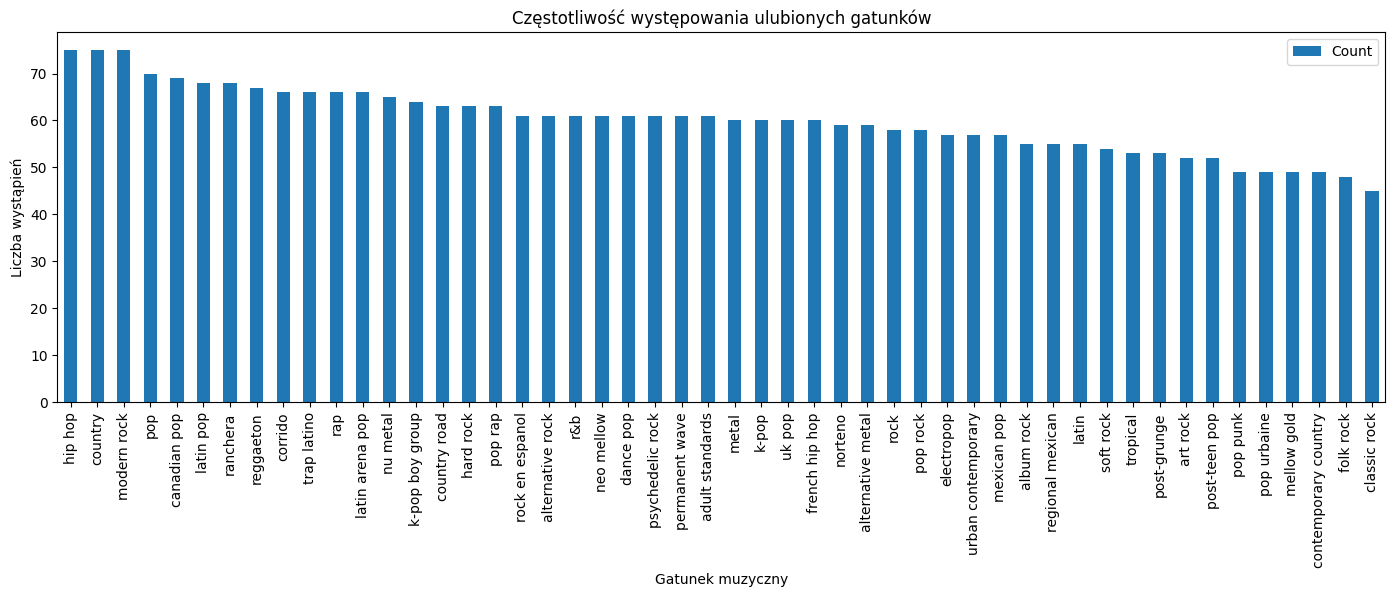

In [81]:
from collections import Counter

flattened_genres = [genre for sublist in users_df['favourite_genres'] for genre in sublist]
genre_counts = Counter(flattened_genres)
genre_counts_df = pd.DataFrame.from_dict(genre_counts, orient='index', columns=['Count'])
sorted_genre_counts = genre_counts_df.sort_values(by='Count', ascending=False)

plt.figure(figsize=(20, 5))
sorted_genre_counts.plot(kind='bar')
plt.subplots_adjust(right=2.2)
plt.title('Częstotliwość występowania ulubionych gatunków')
plt.xlabel('Gatunek muzyczny')
plt.xticks(rotation=90)
plt.ylabel('Liczba wystąpień')
plt.show()

### Wnioski
- Nie ma informacji o imieniu, mieście i ulicy, ich nie potrzebujemy. Ale przydałaby się informacja o państwie użytkownika w przypadku rekomendacji dla nowego użytkownika. 
- Ulubione gatunki mogą być przydatne do rekomendacji gdy nie mamy danych historycznych użytkownika.

#### Wykresy
- Mamy zróżnicowanych użytkowników którzy lubią zróżnicowane gatunki muzyczne.

# Wnioski końcowe
- Jesteśmy pewni, że zmienne wejściowe niosą realną informację o zmiennej celu
- Uważamy, że dane są wystarczające dla rozwiązania zadania